# Data Processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,  GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, silhouette_score, plot_confusion_matrix, plot_roc_curve, make_scorer, recall_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import seaborn as sbn
from pipeline_utils import ColumnRemover
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('high_diamond_ranked_10min.csv')
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
data['blueWins'].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

## Removing Duplicate or Dependent Columns

In [4]:
to_drop = ['gameId','blueGoldDiff','blueExperienceDiff','redFirstBlood','redGoldDiff','redExperienceDiff']
data = data.drop(to_drop, axis = 1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

## Setting columns to categorical or numeric

In [6]:
cat_cols = ['blueFirstBlood']
num_cols = []
for col in data:
    if col not in cat_cols:
        num_cols.append(col)
num_cols.remove('blueWins')

## Plotting Boxplots

In [7]:
#for col in num_cols:
#    fig = sbn.boxplot(data = data, x='blueWins', y=col, palette=['red','blue'])
#    fig.set_xticklabels(labels=['Red Wins','Blue Wins'])
#    plt.title('Boxplot of '+str(col))
#    plt.xlabel('Game Outcome')
#    plt.savefig('exploratory_plots/'+str(col)+'_fig')
#    plt.clf()

## Performing PCA

In [8]:
scl_data = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]))
scl_data.to_csv('R_Cross_Val/cross_val_with_R.csv')

In [9]:
dpca = PCA().fit(scl_data)

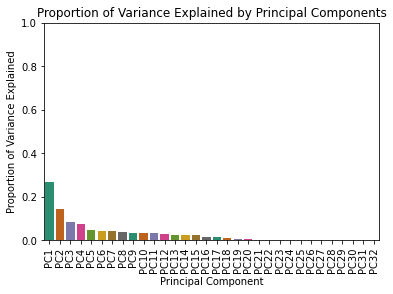

In [10]:
pcs = ['PC'+str(i) for i in range(1, dpca.n_features_+1)]

bplot = sbn.barplot(x = pcs, y = dpca.explained_variance_ratio_, palette='Dark2')
bplot.set_xticklabels(labels = pcs,rotation=90)
plt.ylim(0,1)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained by Principal Components')
plt.show()

In [11]:
pd.DataFrame({
    'Principal Components' : pcs, 
    'Explained Variance' : dpca.explained_variance_ratio_
    })

,Principal Components,Explained Variance
0,PC1,2.668199e-01
1,PC2,1.441336e-01
2,PC3,8.135344e-02
3,PC4,7.648449e-02
4,PC5,4.718745e-02
5,PC6,4.319455e-02
6,PC7,4.046784e-02
7,PC8,3.928082e-02
8,PC9,3.460086e-02
9,PC10,3.271791e-02


There is a significant decrease in variance explained from by all principal components after the 23rd. Removing components \[24, 31].

In [12]:
dpca.components_.T[:,0:3]

array([[ 7.52349110e-03,  9.73665164e-03, -2.04186734e-02],
       [ 3.14926159e-02, -2.56274713e-02, -3.07768038e-03],
       [ 2.22275282e-01,  3.08525204e-01,  6.69606808e-02],
       [-2.16671109e-01,  3.16985534e-01, -2.47677689e-02],
       [ 1.84896572e-01,  2.71362468e-01,  4.57331655e-02],
       [ 1.38192635e-01, -9.84347908e-03, -4.35358564e-01],
       [ 1.21319595e-01, -5.26164901e-03, -4.42171016e-01],
       [ 7.20154637e-02, -9.28721470e-03, -1.53110604e-01],
       [ 9.43679436e-02,  6.53586295e-02,  3.07749249e-02],
       [ 2.72014863e-01,  2.12388824e-01,  1.07922338e-01],
       [ 2.35220486e-01, -5.68767839e-02,  1.11577569e-01],
       [ 2.54070672e-01, -6.35186179e-02,  1.12837851e-01],
       [ 1.60236045e-01, -2.28450931e-01,  1.35915731e-01],
       [ 6.67013672e-02, -1.41624581e-01, -6.47887185e-02],
       [ 1.60236045e-01, -2.28450931e-01,  1.35915731e-01],
       [ 2.72014863e-01,  2.12388824e-01,  1.07922338e-01],
       [-8.37530879e-03, -8.03736960e-03

In [13]:
dpca.explained_variance_

array([8.53910221e+00, 4.61274201e+00, 2.60357375e+00, 2.44775148e+00,
       1.51015121e+00, 1.38236545e+00, 1.29510184e+00, 1.25711360e+00,
       1.10733962e+00, 1.04707900e+00, 1.02927223e+00, 8.92825203e-01,
       8.05618835e-01, 7.91331514e-01, 7.57532503e-01, 4.85274336e-01,
       4.03553664e-01, 3.31196027e-01, 2.35701005e-01, 1.84691550e-01,
       8.06370914e-02, 7.50275145e-02, 6.87459250e-02, 5.95119720e-02,
       1.68404098e-30, 1.08152128e-31, 8.22203666e-32, 6.30544957e-32,
       5.55407133e-32, 4.32193054e-32, 3.83497179e-32, 1.56726506e-32])

## Splitting Training and Test

In [14]:
train_data, test_data = train_test_split(data, stratify = data['blueWins'], test_size = 0.2, random_state=43)

In [15]:
train_data['blueWins'].value_counts()

0    3959
1    3944
Name: blueWins, dtype: int64

## Preprocessing

In [16]:
numerical_transform = Pipeline(steps=[
    ('Scaler', StandardScaler()),
    ('PCA', PCA()),
    ('Component Remover', ColumnRemover(rm_cols=[i for i in range(24,32)]))
])

preprocessor = ColumnTransformer(transformers = [
    ('Numeric Transforms', numerical_transform, num_cols)
], remainder = 'passthrough', n_jobs=-1)

In [17]:
y_train = train_data['blueWins']
x_train = train_data.drop('blueWins', axis=1)

y_test = test_data['blueWins']
x_test = test_data.drop('blueWins', axis=1)

## Performing Cluster Analysis

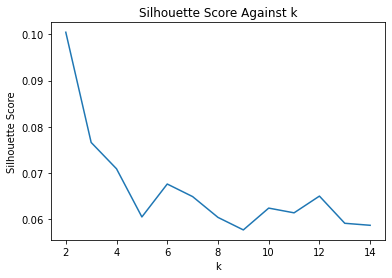

In [18]:
x_tmp = preprocessor.fit_transform(x_train)

sil = []
ks = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k,random_state=67).fit(x_tmp)
    sil.append(silhouette_score(x_tmp,kmeans.labels_,metric='manhattan'))
    ks.append(k)
plt.plot(ks,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Against k')
plt.show()

Silhouette scores indicate poor clustering. Thus, clustering will be removed from the model.

# Building Models

In [19]:
cv = KFold(n_splits=3, random_state=758, shuffle=True)
macro_recall = make_scorer(recall_score, average='macro')

In [20]:
train_data, test_data = train_test_split(data, stratify = data['blueWins'], test_size = 0.6, random_state=43)

y_train = train_data['blueWins']
x_train = train_data.drop('blueWins', axis=1)

y_test = test_data['blueWins']
x_test = test_data.drop('blueWins', axis=1)

## k-Nearest Neighbours Classifier

In [21]:
#Optimising model in region about default values
params = {
    'KNN__n_neighbors' : [i for i in range(5,10)],
    'KNN__leaf_size' : [i for i in range(25,35)]
}

knn = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('KNN', KNeighborsClassifier())
])

gd_sr = GridSearchCV(estimator=knn,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose = 10)
gd_sr.fit(x_train,y_train)
knn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   23.0s remaining:    1.0s
Optimal Paramaters: {'KNN__leaf_size': 25, 'KNN__n_neighbors': 9}
[Parallel(n_jobs=-1)]: Done 150 

In [22]:
print('\n')
print('k-Nearest Neighbours Train Data Report')
print(classification_report(y_pred = knn.predict(x_train), y_true = y_train))

print('\n')
print('k-Nearest Neighbours Test Data Report')
print(classification_report(y_pred = knn.predict(x_test), y_true = y_test))



k-Nearest Neighbours Train Data Report
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1979
           1       0.78      0.76      0.77      1972

    accuracy                           0.77      3951
   macro avg       0.77      0.77      0.77      3951
weighted avg       0.77      0.77      0.77      3951



k-Nearest Neighbours Test Data Report
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2970
           1       0.70      0.70      0.70      2958

    accuracy                           0.70      5928
   macro avg       0.70      0.70      0.70      5928
weighted avg       0.70      0.70      0.70      5928



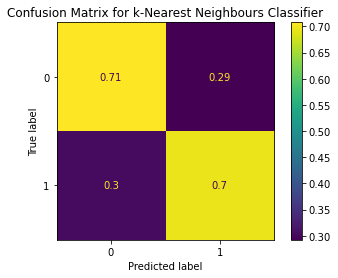

In [23]:
plot_confusion_matrix(knn,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for k-Nearest Neighbours Classifier')
plt.show()

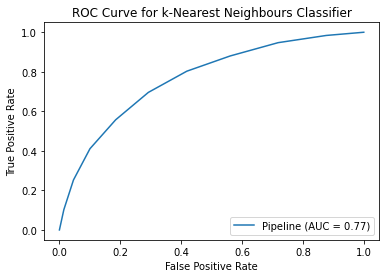

In [24]:
plot_roc_curve(knn,x_test,y_test)
plt.title('ROC Curve for k-Nearest Neighbours Classifier')
plt.show()

## Logistic Regression

In [25]:
#Optimising model in region about default values
params = {
    'LR__C' : [i/10 for i in range(0,11)]
}

clf = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('LR', LogisticRegression(random_state=82))
])

gd_sr = GridSearchCV(estimator=clf,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
clf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  14 out of  33 | elapsed:    0.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    1.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  26 out of  33 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  33 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    1.5s finished
Optimal Paramaters: {'LR__C': 0.5}


In [26]:
print('Logistic Regression')

print('\n')
print('Logistic Regression Train Data Report')
print(classification_report(y_pred = clf.predict(x_train), y_true = y_train))

print('\n')
print('Logistic Regression Test Data Report')
print(classification_report(y_pred = clf.predict(x_test), y_true = y_test))

Logistic Regression


Logistic Regression Train Data Report
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1979
           1       0.74      0.74      0.74      1972

    accuracy                           0.74      3951
   macro avg       0.74      0.74      0.74      3951
weighted avg       0.74      0.74      0.74      3951



Logistic Regression Test Data Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2970
           1       0.73      0.73      0.73      2958

    accuracy                           0.73      5928
   macro avg       0.73      0.73      0.73      5928
weighted avg       0.73      0.73      0.73      5928



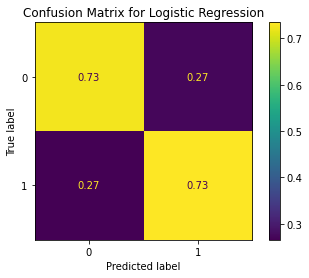

In [27]:
plot_confusion_matrix(clf,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

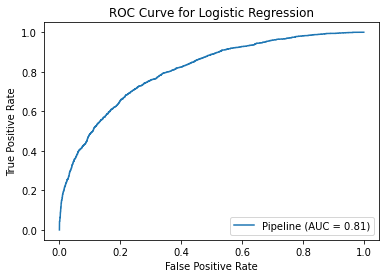

In [28]:
plot_roc_curve(clf,x_test,y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()

## Neural Network

In [29]:
#Optimising model in region about default values
params = {
    'NN__hidden_layer_sizes' : [(90,),(100,),(110,),(90,90),(100,100),(110,110),(90,90,90),(100,100,100),(110,110,110)]
}

cnn = Pipeline(steps=[
    ('Preprocessing', preprocessor),
    ('NN', MLPClassifier(random_state=29))
])

gd_sr = GridSearchCV(estimator=cnn,param_grid=params,cv=cv,n_jobs=-1, scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
cnn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   7 out of  27 | elapsed:   18.9s remaining:   54.1s
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:   32.2s remaining:   54.8s
[Parallel(n_jobs=-1)]: Done  13 out of  27 | elapsed:   50.5s remaining:   54.4s
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:   54.0s remaining:   37.1s
[Parallel(n_jobs=-1)]: Done  19 out of  27 | elapsed:  1.0min remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:  1.0min remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:  1.2min remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.2min finished
Optimal Paramaters: {'NN__hidden_layer_sizes': (100,)}


In [30]:
print('\n')
print('Neural Network Train Data Report')
print(classification_report(y_pred = cnn.predict(x_train), y_true = y_train))

print('\n')
print('Neural Network Test Data Report')
print(classification_report(y_pred = cnn.predict(x_test), y_true = y_test))



Neural Network Train Data Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1979
           1       0.88      0.86      0.87      1972

    accuracy                           0.87      3951
   macro avg       0.87      0.87      0.87      3951
weighted avg       0.87      0.87      0.87      3951



Neural Network Test Data Report
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      2970
           1       0.69      0.67      0.68      2958

    accuracy                           0.69      5928
   macro avg       0.69      0.69      0.69      5928
weighted avg       0.69      0.69      0.69      5928



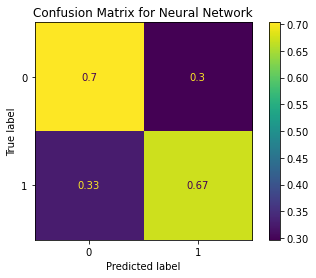

In [31]:
plot_confusion_matrix(cnn, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Neural Network')
plt.show()

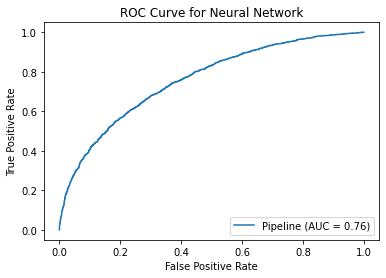

In [32]:
plot_roc_curve(cnn,x_test,y_test)
plt.title('ROC Curve for Neural Network')
plt.show()

## Random Forest

In [33]:
#Optimising model in region about default values
params = {
    'RF__n_estimators' : [i*10 for i in range(7,14)],
    'RF__min_samples_split' : [i for i in range(2,5)]
}

crf = Pipeline(steps=[
    ('Preprocessing', preprocessor),
    ('RF', RandomForestClassifier(random_state=32))
])

gd_sr = GridSearchCV(estimator=crf,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
crf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  47 out of  63 | elapsed:   20.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  54 out of  63 | elapsed:   23.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:   27.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   27.8s finished
Optimal Paramaters: {'RF__min_samples_split': 4, 'RF__n_estimators': 120}


In [34]:
print('\n')
print('Random Forest Train Data Report')
print(classification_report(y_pred = crf.predict(x_train), y_true = y_train))

print('\n')
print('Random Forest Test Data Report')
print(classification_report(y_pred = crf.predict(x_test), y_true = y_test))



Random Forest Train Data Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1979
           1       1.00      1.00      1.00      1972

    accuracy                           1.00      3951
   macro avg       1.00      1.00      1.00      3951
weighted avg       1.00      1.00      1.00      3951



Random Forest Test Data Report
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      2970
           1       0.72      0.73      0.72      2958

    accuracy                           0.72      5928
   macro avg       0.72      0.72      0.72      5928
weighted avg       0.72      0.72      0.72      5928



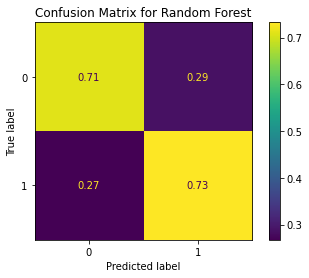

In [35]:
plot_confusion_matrix(crf, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Random Forest')
plt.show()

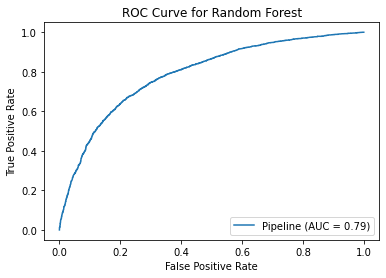

In [36]:
plot_roc_curve(crf,x_test,y_test)
plt.title('ROC Curve for Random Forest')
plt.show()

## AdaBoost

In [37]:
#Optimising model in region about default values
params = {
    'AD__n_estimators' : [i*10 for i in range(4,7)],
}

cad = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('AD', AdaBoostClassifier(random_state=32, base_estimator=LogisticRegression()))
])

gd_sr = GridSearchCV(estimator=cad,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall, verbose=10)
gd_sr.fit(x_train,y_train)
cad = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    1.2s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    1.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    1.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.7s finished
Optimal Paramaters: {'AD__n_estimators': 40}


In [38]:
print('\n')
print('ADA Boost Train Data Report')
print(classification_report(y_pred = cad.predict(x_train), y_true = y_train))

print('\n')
print('ADA Boost Test Data Report')
print(classification_report(y_pred = cad.predict(x_test), y_true = y_test))



ADA Boost Train Data Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1979
           1       0.73      0.74      0.74      1972

    accuracy                           0.74      3951
   macro avg       0.74      0.74      0.74      3951
weighted avg       0.74      0.74      0.74      3951



ADA Boost Test Data Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      2970
           1       0.73      0.74      0.73      2958

    accuracy                           0.73      5928
   macro avg       0.73      0.73      0.73      5928
weighted avg       0.73      0.73      0.73      5928



## Voting Classifier

In [39]:
cvt = Pipeline(steps = [
    ('VC', VotingClassifier(estimators=[('ad', cad),('lf', clf),('rf', crf)], voting='hard'))
])
cvt = cvt.fit(x_train,y_train)

In [40]:
print('\n')
print('Voting Classifier Train Data Report')
print(classification_report(y_pred = cvt.predict(x_train), y_true = y_train))

print('\n')
print('Voting Classifier Test Data Report')
print(classification_report(y_pred = cvt.predict(x_test), y_true = y_test))



Voting Classifier Train Data Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1979
           1       0.74      0.75      0.75      1972

    accuracy                           0.75      3951
   macro avg       0.75      0.75      0.75      3951
weighted avg       0.75      0.75      0.75      3951



Voting Classifier Test Data Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      2970
           1       0.73      0.74      0.73      2958

    accuracy                           0.73      5928
   macro avg       0.73      0.73      0.73      5928
weighted avg       0.73      0.73      0.73      5928



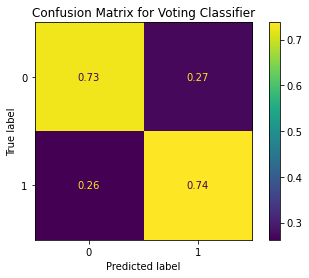

In [41]:
plot_confusion_matrix(cvt, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Voting Classifier')
plt.show()

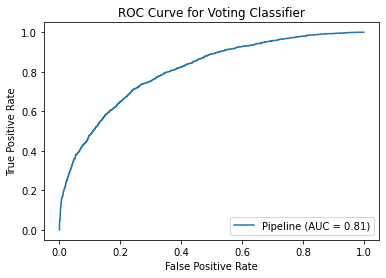

In [42]:
plot_roc_curve(cad,x_test,y_test)
plt.title('ROC Curve for Voting Classifier')
plt.show()

# Comparison of Model Performance on Cross Validation

In [43]:
cv = KFold(n_splits=10, random_state=40, shuffle=True)
accs = {'trial' : [i for i in range(1,11)]}
rs = {'trial' : [i for i in range(1,11)]}

In [44]:
accs['Voting Classifier - Accuracy'] = cross_val_score(estimator=cvt,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Voting Classifier - Macro Recall'] = cross_val_score(estimator=cvt,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs['AdaBoost - Accuracy'] = cross_val_score(estimator=cad,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['AdaBoost - Macro Recall'] = cross_val_score(estimator=cad,X=x_train,y=y_train,scoring=macro_recall, cv=cv, n_jobs=-1)

accs['Random Forest - Accuracy'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Random Forest - Macro Recall'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring=macro_recall, cv=cv, n_jobs=-1)

accs['Neural Network - Accuracy'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Neural Network - Macro Recall'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['Logistic Regression - Accuracy'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Logistic Regression - Macro Recall'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['k-Nearest Neighbours - Accuracy'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
rs['k-Nearest Neighbours - Macro Recall'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs = pd.DataFrame(accs)
rs = pd.DataFrame(rs)

In [45]:
accs

,trial,Voting Classifier - Accuracy,AdaBoost - Accuracy,Random Forest - Accuracy,Neural Network - Accuracy,Logistic Regression - Accuracy,k-Nearest Neighbours - Accuracy
0,1,0.724747,0.724747,0.734848,0.676768,0.717172,0.676768
1,2,0.711392,0.708861,0.688608,0.688608,0.713924,0.665823
2,3,0.698734,0.703797,0.706329,0.675949,0.701266,0.658228
3,4,0.769620,0.767089,0.756962,0.731646,0.764557,0.726582
4,5,0.731646,0.726582,0.731646,0.739241,0.746835,0.688608
5,6,0.759494,0.754430,0.759494,0.726582,0.759494,0.736709
6,7,0.754430,0.751899,0.736709,0.683544,0.746835,0.724051
7,8,0.772152,0.772152,0.762025,0.701266,0.764557,0.691139
8,9,0.739241,0.739241,0.726582,0.703797,0.736709,0.696203
9,10,0.706329,0.708861,0.698734,0.658228,0.698734,0.693671


In [46]:
rs

,trial,Voting Classifier - Macro Recall,AdaBoost - Macro Recall,Random Forest - Macro Recall,Neural Network - Macro Recall,Logistic Regression - Macro Recall,k-Nearest Neighbours - Macro Recall
0,1,0.725387,0.725054,0.736198,0.676700,0.717612,0.673370
1,2,0.712385,0.709740,0.688794,0.689449,0.714812,0.666731
2,3,0.696674,0.701754,0.705034,0.674255,0.699362,0.655438
3,4,0.768232,0.765572,0.756154,0.730779,0.763645,0.727413
4,5,0.732239,0.727166,0.731803,0.739739,0.747239,0.686829
5,6,0.757825,0.752758,0.757825,0.724959,0.757825,0.735799
6,7,0.753914,0.751129,0.735923,0.682117,0.746561,0.723001
7,8,0.771901,0.771991,0.762130,0.701531,0.764348,0.691581
8,9,0.739194,0.739207,0.726581,0.703776,0.736643,0.696226
9,10,0.706380,0.709284,0.697913,0.659022,0.698402,0.694791


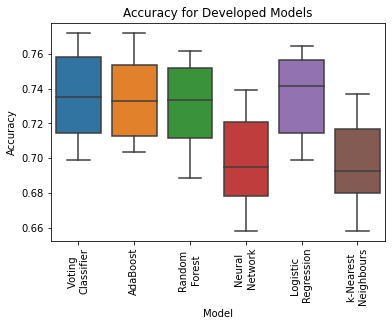

In [47]:
bplot = sbn.boxplot(data=accs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Voting \nClassifier', 'AdaBoost', 'Random \nForest','Neural \nNetwork','Logistic \nRegression','k-Nearest \nNeighbours'],rotation=90)
plt.title('Accuracy for Developed Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

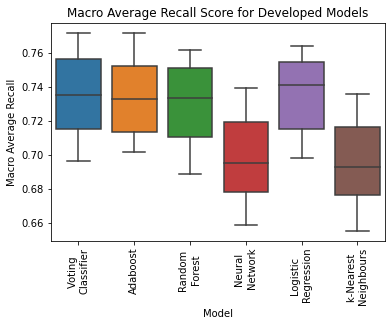

In [48]:
bplot = sbn.boxplot(data=rs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Voting \nClassifier', 'Adaboost', 'Random \nForest','Neural \nNetwork','Logistic \nRegression','k-Nearest \nNeighbours'],rotation=90)
plt.title('Macro Average Recall Score for Developed Models')
plt.xlabel('Model')
plt.ylabel('Macro Average Recall')
plt.show()